In [23]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import seaborn as sns 
import missingno as msno 

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


import imblearn
from imblearn.over_sampling import SMOTE


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

- Read needed tables.

In [10]:
y_all_train = pd.read_csv("../data/y_all_train.csv").match_result
y_all_test = pd.read_csv("../data/y_all_test.csv").match_result

X_all_train_std = pd.read_csv("../data/X_all_train_std.csv")
X_all_test_std = pd.read_csv("../data/X_all_test_std.csv")

- Since it is hard to predict the draw in the multiclass classification problem, let's train the model only for predicting the draw.
- After predict draw matches, let's train a model to predict home_win. Then we can classify the rest of the non-draw matches as home_win and away_win.

# 1. Predict draws

- Re-label match results as draw or non-draw.

In [11]:
y_all_train_relabel = y_all_train.replace({"home_win": "non_draw", "away_win": "non_draw"})
y_all_test_relabel = y_all_test.replace({"home_win": "non_draw", "away_win": "non_draw"})

## 1.1. Baseline accuracy

In [12]:
y_all_train_relabel.value_counts()

non_draw    12695
draw         4293
Name: match_result, dtype: int64

<AxesSubplot:xlabel='match_result', ylabel='count'>

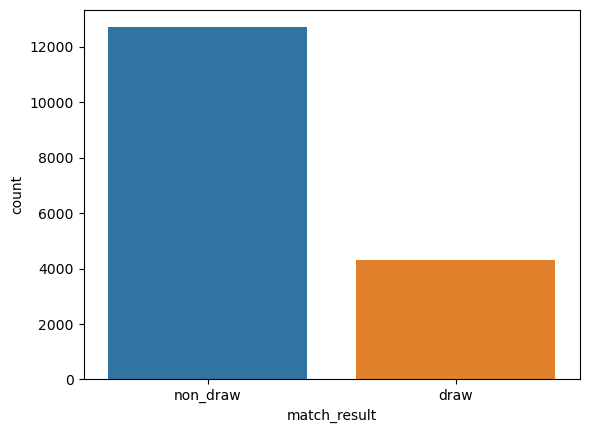

In [13]:
sns.countplot(x = y_all_train_relabel)

- About 75% of all 16,988 matches were non_draw.
- That is, if we predict all matches as non_draw, then we can achieve about 75% accuracy, that can be used as our baseline accuracy.

- Let's check the baseline accuracy in the test data set.

In [14]:
y_all_test_relabel.value_counts()

non_draw    1962
draw         659
Name: match_result, dtype: int64

<AxesSubplot:xlabel='match_result', ylabel='count'>

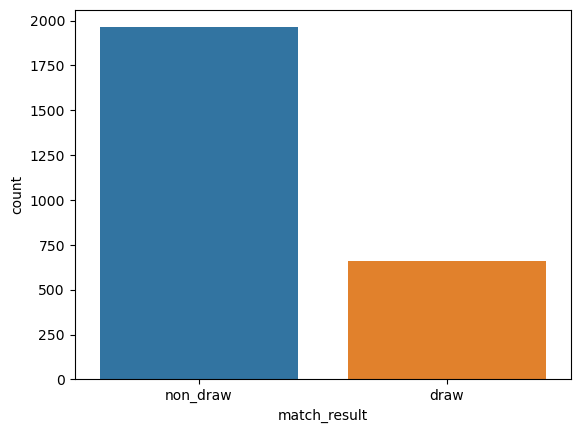

In [15]:
sns.countplot(x = y_all_test_relabel)

- Baseline accuracy in the test dataset is about 75% (1,962 / 2,621)

## 1.2. Modeling with default hyperparameters

- Let's compare the models before tune hyperparameters.

- Transform the re-labeled match result to numeric value.

In [16]:
le_relabel = preprocessing.LabelEncoder()
le_relabel.fit(y_all_train_relabel)

y_all_train_relabel_encd = le_relabel.transform(y_all_train_relabel)
y_all_test_relabel_encd = le_relabel.transform(y_all_test_relabel)

In [17]:
names = ["KNN", 
         "LDA", 
         "QDA", 
         "Naive Bayes",
         "Logistic regression",
         "Decesion tree", 
         "Random Forest",  
         "AdaBoost",
         "XGBoost",
         "Polynomial kernel SVM",
         "Radial kernel SVM",
         "GBM",
         "LightGBM"
        ]

classifiers = [
    KNeighborsClassifier(3),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(), 
    LogisticRegression(),
    DecisionTreeClassifier(random_state = 42),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    xgb.XGBClassifier(),
    SVC(kernel = "poly", probability = True),
    SVC(kernel = "rbf", probability = True),
    GradientBoostingClassifier(),
    lgb.LGBMClassifier()
    ]

In [18]:
result_accuracy = pd.DataFrame(names, columns = ["model_name"])

In [19]:
# baseline accuracy

y_pred_baseline = le_relabel.transform(["non_draw"])
baseline_accuracy = np.mean(y_pred_baseline == y_all_test_relabel_encd)
result_accuracy["Baseline accuracy"] = baseline_accuracy

In [25]:
y_pred_dict = {}

for name, clf in zip(names, classifiers):
    clf.fit(X_all_train_std, y_all_train_relabel_encd)
    
    y_pred = clf.predict(X_all_test_std)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_all_test_relabel_encd)
    precision = precision_score(y_all_test_relabel_encd, y_pred)
    recall = recall_score(y_all_test_relabel_encd, y_pred, pos_label = 0)
    
    result_accuracy.loc[result_accuracy.model_name == name, "Accuracy"] = round(accuracy * 100, 3)
    result_accuracy.loc[result_accuracy.model_name == name, "Recall"] = round(recall * 100, 3)

In [ ]:
result_accuracy

# 2. Predict home wins